In [1]:
%matplotlib notebook

In [2]:
from pathlib import Path
from dask import array as da
from skimage.transform import rescale
import imageio.v2 as iio

from matplotlib import pyplot as plt

In [29]:
import numpy as np

In [3]:
fp = Path('Y:/SmartSPIM/Stitched/585764/')
channels = {i.stem.split('_')[1]:i for i in fp.glob('Ex*')}
channels

{'488': WindowsPath('Y:/SmartSPIM/Stitched/585764/Ex_488_Em_525_stitched.zr'),
 '561': WindowsPath('Y:/SmartSPIM/Stitched/585764/Ex_561_Em_600_stitched.zr')}

In [4]:
green_vol = da.from_zarr(str(channels['488']), 2)
red_vol = da.from_zarr(str(channels['561']), 2)

<IPython.core.display.Javascript object>


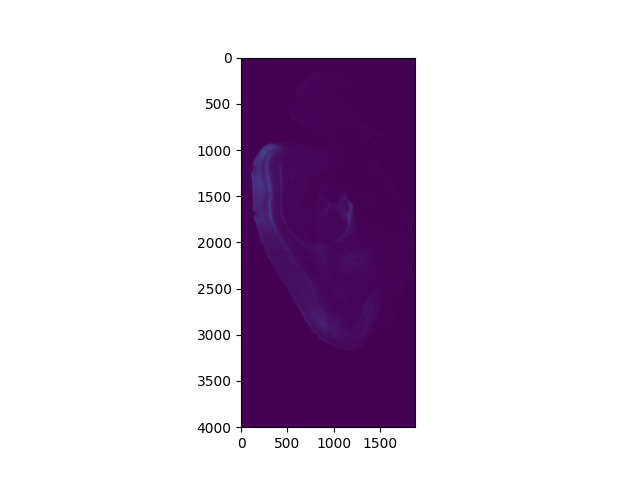

In [6]:
im = green_vol[600,...]
plt.figure()
plt.imshow(im)

In [7]:
tpose = [1,2,0]


In [10]:
green_vol_coronal = green_vol.transpose(tpose)
green_vol_coronal

dask.array<transpose, shape=(4002, 1879, 1240), dtype=uint16, chunksize=(1024, 1024, 1), chunktype=numpy.ndarray>

<IPython.core.display.Javascript object>


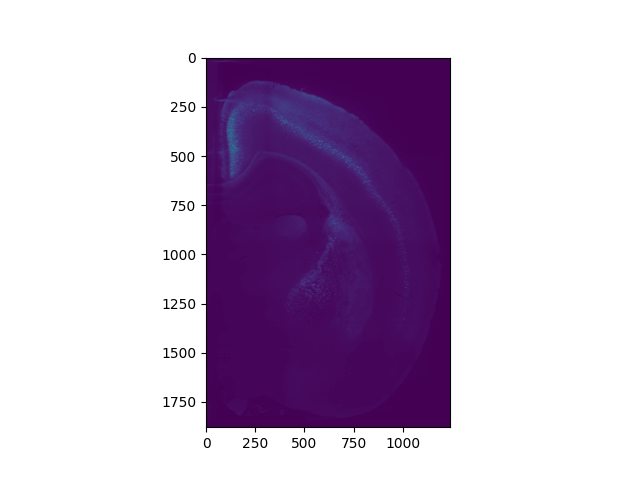

In [12]:
plt.figure()
plt.imshow(green_vol_coronal[2000,...])

In [13]:
limits = [600,400]
red_vol_coronal = red_vol.transpose(tpose)

movie_out = Path('rat_coronal_redo.mp4')

In [26]:
from tqdm.auto import tqdm

In [15]:
from dask.distributed import Client

In [16]:
client = Client()

In [17]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 64,Total memory: 127.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:55363,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 64
Started: Just now,Total memory: 127.88 GiB
Comm: tcp://127.0.0.1:55423,Total threads: 8
Dashboard: http://127.0.0.1:55424/status,Memory: 15.98 GiB
Nanny: tcp://127.0.0.1:55373,


In [18]:
green_vol_coronal_mem = green_vol_coronal.compute()


In [19]:
red_vol_coronal_mem = red_vol_coronal.compute()

<IPython.core.display.Javascript object>


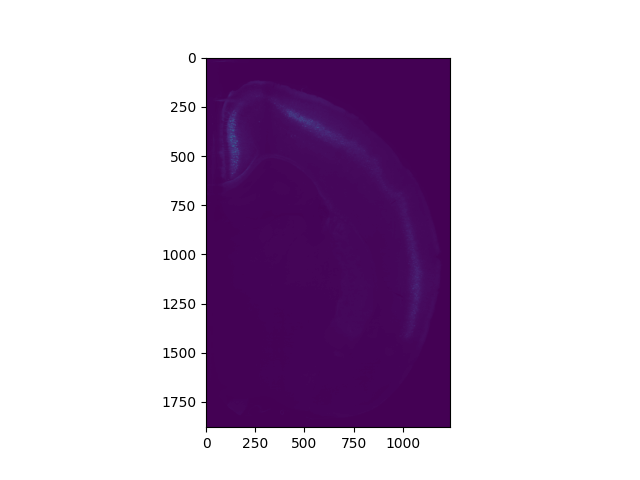

In [20]:
plt.figure()
plt.imshow(red_vol_coronal_mem[2000])

In [44]:
writer = iio.get_writer(movie_out, fps=30)

for f in tqdm(range(green_vol_coronal_mem.shape[0])):
    fr = -1-f
    img = green_vol_coronal_mem[fr,...]
    imr = red_vol_coronal_mem[fr,...]
    image = np.zeros(img.shape+(3,))
    imgsc = np.clip(img*(255/400), a_min=0, a_max=255).astype(int)
    imrsc = np.clip(imr*(255/600), a_min=0, a_max=255).astype(int)
    image[...,1] = imgsc
    image[...,0] = imrsc
    imagescale = rescale(image, (1, 2/1.8,1), preserve_range=True).astype('uint8')
    writer.append_data(imagescale)

  0%|          | 0/4002 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1378, 1879) to (1392, 1888) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [45]:
writer.close()

In [34]:
image.shape

(1879, 1240, 3)

In [22]:
from importlib import reload

In [23]:
reload(iio)

<module 'imageio.v2' from 'C:\\Users\\User\\.conda\\envs\\brainreg\\lib\\site-packages\\imageio\\v2.py'>

In [39]:
writer.close()

<IPython.core.display.Javascript object>


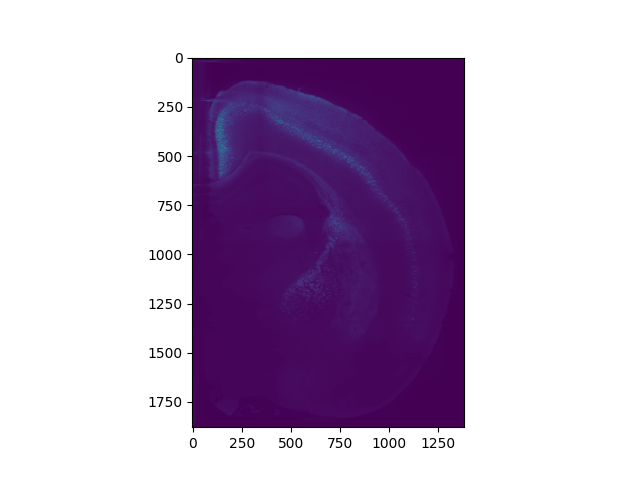

In [41]:
testIm = green_vol_coronal_mem[2000]
plt.figure()
plt.imshow(rescale(testIm, (1,2/1.8)))